## Importing Libraries

In [5]:
#SparkContext.setSystemProperty('spark.executor.pyspark.memory', '8g')
#from pyspark import SparkFiles
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import joblib



## Importing the cleaned file from S3

In [7]:
# read the csv which is stored in AWS s3 bucket
df = pd.read_csv("https://icdrive1.s3.amazonaws.com/drug_review_data_cleaned.csv",sep=",")
df.head()

,Unnamed: 0,_c0,uniqueID,drugName,condition,review,rating,usefulCount,review_date,review_outcome,pos,neg,label
0,0,0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,27,2012-05-20,Positive,0.000,0.136,1
1,1,1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,192,2010-04-27,Positive,0.111,0.018,1
2,2,2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,17,2009-12-14,Negative,0.083,0.062,0
3,3,3,138000,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,10,2015-11-03,Positive,0.093,0.027,1
4,4,4,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,37,2016-11-27,Positive,0.178,0.064,1


In [8]:
#creating new dataframe with just review and rating column
df2 = df[['uniqueID','review','rating']]
df2.head()

,uniqueID,review,rating
0,206461,"It has no side effect, I take it in combinatio...",9
1,95260,My son is halfway through his fourth week of I...,8
2,92703,"I used to take another oral contraceptive, whi...",5
3,138000,This is my first time using any form of birth ...,8
4,35696,Suboxone has completely turned my life around....,9


In [9]:
#checking for null value
df2.isnull().any().any()

False

In [10]:
# downloading punkt and stopwords from nltk
import nltk
#nltk.download(['punkt','stopwords'])

In [11]:
#importing stopwords from nltk 
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

## Analyzing using Vader Sentiment Analyzer

In [13]:
#Vader library is used for sentiment analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [14]:
#Assigning a score based on analyzing the review column
df2['vaderReviewScore']=df2['review'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

In [15]:
#showing the dataframe
df2.head()

,uniqueID,review,rating,vaderReviewScore
0,206461,"It has no side effect, I take it in combinatio...",9,-0.2960
1,95260,My son is halfway through his fourth week of I...,8,0.9174
2,92703,"I used to take another oral contraceptive, whi...",5,0.6160
3,138000,This is my first time using any form of birth ...,8,0.7184
4,35696,Suboxone has completely turned my life around....,9,0.9403


In [16]:
#positive and negative score is assigning based on vaderreview score
pos_num = len(df2[df2['vaderReviewScore'] >=0.05])
neg_num = len(df2[df2['vaderReviewScore'] <= 0.05])

In [17]:
#displaying the total number of positive and negative category
pos_num,neg_num

(100167, 114898)

In [18]:
#converitng into 1 or 0 label
df2['vaderSentiment']=df2['vaderReviewScore'].map(lambda x:int(1) if x>=0.05 else int(0))

In [19]:
# displaying each count
df2['vaderSentiment'].value_counts()

0    114896
1    100167
Name: vaderSentiment, dtype: int64

In [20]:
#based on review score divide into positive and negative sentiment
df2.loc[df2['vaderReviewScore'] >= 0.05,"vadersentimentlabel"] = "positive"
df2.loc[df2['vaderReviewScore'] <= 0.05,"vadersentimentlabel"] = "negative"

In [21]:
#displaying dataframe with vader score and label
df2.head()

,uniqueID,review,rating,vaderReviewScore,vaderSentiment,vadersentimentlabel
0,206461,"It has no side effect, I take it in combinatio...",9,-0.2960,0,negative
1,95260,My son is halfway through his fourth week of I...,8,0.9174,1,positive
2,92703,"I used to take another oral contraceptive, whi...",5,0.6160,1,positive
3,138000,This is my first time using any form of birth ...,8,0.7184,1,positive
4,35696,Suboxone has completely turned my life around....,9,0.9403,1,positive


In [17]:
## Saving this output as csv for using in Tableau
df2[["uniqueID","vaderSentiment","vaderReviewScore"]].to_csv(os.path.join("../static/db/vader_score.csv"))

In [22]:
# rating based on rating column
pos_rating = len(df2[df2['rating'] >= 5])
neg_rating = len(df2[df2['rating'] <= 5])

In [23]:
#number of each column
pos_rating,neg_rating

(161491, 64295)

In [24]:
#if rating is more that 5 consider it as label 1 else 0
df2['ratingsentiment']=df2['rating'].map(lambda x:int(1) if x>=5 else int(0))

In [25]:
#displaying each rating catagory
df2['ratingsentiment'].value_counts()

1    161491
0     53572
Name: ratingsentiment, dtype: int64

In [26]:
#assigning positive and negative rating based on start rating
df2.loc[df2['rating'] >= 5,"ratingsentimentlabel"] = "positive"
df2.loc[df2['rating'] <= 5,"ratingsentimentlabel"] = "negative"

In [27]:
#dispalying the dataframe with review ,rating and with both label
df2.head()

,uniqueID,review,rating,vaderReviewScore,vaderSentiment,vadersentimentlabel,ratingsentiment,ratingsentimentlabel
0,206461,"It has no side effect, I take it in combinatio...",9,-0.2960,0,negative,1,positive
1,95260,My son is halfway through his fourth week of I...,8,0.9174,1,positive,1,positive
2,92703,"I used to take another oral contraceptive, whi...",5,0.6160,1,positive,1,negative
3,138000,This is my first time using any form of birth ...,8,0.7184,1,positive,1,positive
4,35696,Suboxone has completely turned my life around....,9,0.9403,1,positive,1,positive


In [28]:
df2.groupby('ratingsentiment').size()

ratingsentiment
0     53572
1    161491
dtype: int64

## Plotting positive word cloud

In [29]:
#calculating positive review based on positive rating label
positive_vader_sentiment = df2[df2.ratingsentiment == 1]
positive_string =[]
for s in positive_vader_sentiment.review:
    positive_string.append(s)
positive_string = pd.Series(positive_string).str.cat(sep='')

In [33]:
#!pip install wordcloud

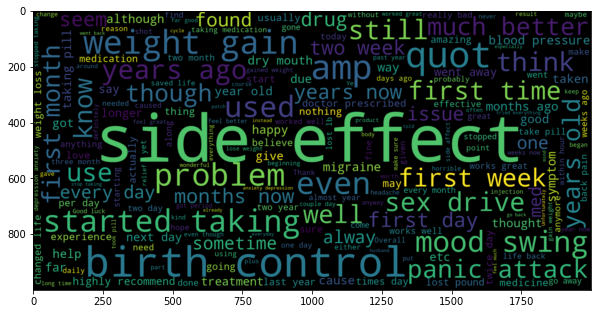

Wall time: 30.7 s


In [38]:
%%time
#ploting word frequency for positive sentiment
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
wordcloud = WordCloud(width=2000,height=1000).generate(positive_string)
plt.imshow(wordcloud,interpolation='bilinear')
plt.savefig("../static/img/word_cloud_happy.png")
plt.show()

In [39]:
for s in positive_vader_sentiment.review[:10]:
    if 'side effect' in s:
        print(s)

It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil
I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it's the end of the third week- I still have daily brown discharge.
The positive side is that I didn't have any other side effects. The idea of being period free was so tempting... Alas.
Abilify changed my life. There is hope. I was on Zoloft and Clonidine when I first started Abilify at the age of 15.. Zoloft for depression and Clondine to manage my complete rage

In [40]:
%%time
#calculating negative review based on negative rating label
negative_vader_sentiment = df2[df2.ratingsentiment == 0]
negative_string =[]
for s in negative_vader_sentiment.review:
    negative_string.append(s)
negative_string = pd.Series(negative_string).str.cat(sep='')

Wall time: 84.8 ms


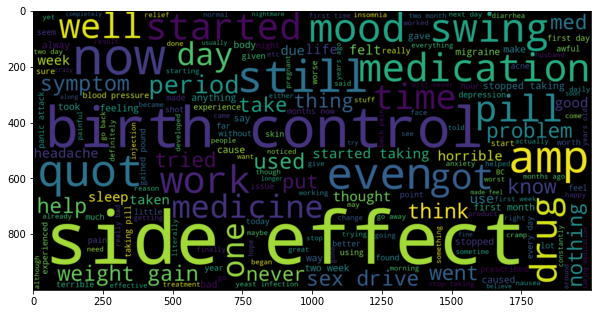

Wall time: 13.4 s


In [41]:
%%time
#ploting word frequency for negative sentiment
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
wordcloud = WordCloud(width=2000,height=1000).generate(negative_string)
plt.imshow(wordcloud,interpolation='bilinear')
plt.savefig("../static/img/word_cloud_sad.png")
plt.show()

## Using NLTK, creating pipeline

In [42]:
#importing Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
%%time
#calculating inverse TF based on review column
tfidf = TfidfVectorizer(stop_words='english',ngram_range=(1,4))
features = tfidf.fit_transform(df2.review)
labels = df2.vaderSentiment

Wall time: 1min 25s


**Saving the vectorizer**


In [44]:
%%time
# Saving the vectorizer
#filename = "vectorizer.sav"
#joblib.dump(tfidf, os.path.join("../static/models",filename),compress=1)

Wall time: 0 ns


In [45]:
#total column of feature variable
#features.shape

## Creating models using different classifiers

In [48]:
%%time
#importing machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

Wall time: 0 ns


**Creating test train data**

In [49]:
%%time
#spliting feature and label variable in to train and test catagory
x_train,x_test,y_train,y_test = train_test_split(df2['review'],df2['ratingsentimentlabel'],random_state=0)

Wall time: 44.9 ms


In [51]:
%%time
#importing different type of classifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

Wall time: 0 ns


In [52]:
%%time
#creating model based on Random Forest,linearSVC,Naive Bayes,LogisticRegresssion Regression 
models = [LinearSVC(),MultinomialNB(),LogisticRegression(random_state=0,solver='lbfgs',max_iter=2000,multi_class='auto')]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model,features,labels,scoring='accuracy',cv=CV)
  for fold_idx,accuracy in enumerate(accuracies):
    entries.append((model_name,fold_idx,accuracy))
cv_df = pd.DataFrame(entries,columns=['model_name','fold_idx','accuracy'])

Wall time: 21min 34s


In [53]:
#displaying accuracy for each model for 5 fold iteration 
cv_df

,model_name,fold_idx,accuracy
0,LinearSVC,0,0.936997
1,LinearSVC,1,0.935926
2,LinearSVC,2,0.938227
3,LinearSVC,3,0.938552
4,LinearSVC,4,0.937297
5,MultinomialNB,0,0.878365
6,MultinomialNB,1,0.878362
7,MultinomialNB,2,0.880963
8,MultinomialNB,3,0.879987
9,MultinomialNB,4,0.879429


In [54]:
#showing based model accuracy
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.937400
LogisticRegression    0.885936
MultinomialNB         0.879421
Name: accuracy, dtype: float64

In [55]:
#importing normalizer for predicting input
from sklearn.preprocessing import Normalizer

## Creating the final model for prediction using the best model (SVM) and training the model

In [56]:
#as SVC is proven for best model based on accuracy will run prediction based on that
model = LinearSVC('l2') #SVM with the square sum of slack variable are called L2-SVM

# Create test and train data

x_train,x_test,y_train,y_test = train_test_split(features,labels,test_size=0.25,random_state=0)
normalize = Normalizer()
x_train = normalize.fit_transform(x_train)
x_test = normalize.transform(x_test)


## Fit the model and predict

In [58]:
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
#accuracy for predicting output is more than 93%
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.9317226500018599


## Save the model

In [59]:
# Saving the model

#filename = 'drugML.sav'
#joblib.dump(model, os.path.join("../static/models",filename))

## Verifying the model

In [70]:
#creating confusion matrix for test and predicted output
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[27228,  1553],
       [ 2118, 22867]], dtype=int64)

## Plotting confusion matrix

In [71]:
#imporing MLxtend library for ploting confusion matrix
from mlxtend.plotting import plot_confusion_matrix

<Figure size 864x864 with 0 Axes>

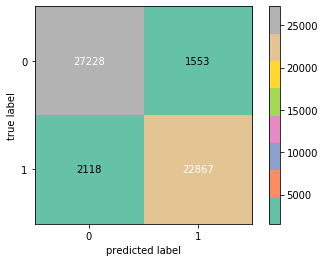

In [79]:
#displaying confusion matrix
fig = plt.figure(figsize=(12,12))
fig,ax = plot_confusion_matrix(conf_mat=conf_mat,colorbar=True,show_absolute=True,cmap='Set2')
fig.savefig("../static/img/confusion.png")

In [53]:
#summary table of SVC model
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,target_names=df2['ratingsentimentlabel'].unique()))

              precision    recall  f1-score   support

    positive       0.93      0.95      0.94     28781
    negative       0.94      0.92      0.93     24985

    accuracy                           0.93     53766
   macro avg       0.93      0.93      0.93     53766
weighted avg       0.93      0.93      0.93     53766



In [54]:
df2.vaderSentiment.unique()

array([0, 1], dtype=int64)

In [55]:
df2.vadersentimentlabel.unique()

array(['negative', 'positive'], dtype=object)

Model prediction is 1,which is positive sentiment label.So it is predicting properly.

## Loading the saved vectorizer and model

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
loaded_model = joblib.load(os.path.join("../static/models", "drugML.sav"))
# loading the vectorizer
loaded_vectorizer = joblib.load(os.path.join("../static/models","vectorizer.sav"))


**Test Case 1**

In [80]:
test_review = ["This drug is horrible"]
print(loaded_model.predict(loaded_vectorizer.transform(test_review)))

[0]


Model prediction is 0,which is negative sentiment label.So it is predicting properly.

**Test Case 2**

In [81]:
#testing the model feeding unknown review
print(loaded_model.predict(loaded_vectorizer.transform(["This drug is the best so far after trying so many other grugs which gave terrible side effect"])))

[1]


**Test Case 3**

In [82]:
print(loaded_model.predict(loaded_vectorizer.transform(["I have only been taking this medication for a week and I am noticing side effects I don't like. I have not been able to sleep properly. I wake up very frequently thorughout the night. I am currently experiencing flu like symptoms and feel feverish. I need to call my doctor to see if these effects would disappear eventually. I am worried."])))

[0]


Model prediction is 0,which is negative sentiment label.So it is predicting properly.